In [1]:
#! git clone https://github.com/angus924/rocket
#! git clone https://github.com/moisesrsantos/tsmorph-xai

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from models import Models
from morph import Morph
from generation import Generation

In [4]:
def getPCA(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

def getTSNE(X, n_components=2):
    tsne = TSNE(n_components=n_components)
    X_tsne = tsne.fit_transform(X)
    return X_tsne
    
def plot_components(X, y):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='viridis', alpha=0.7)
    plt.title('PCA Components', fontsize=14, pad=15)
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Class')
    plt.show()

## Example


In [7]:
gen = Generation(shift=0.08)
X, y = gen.generate_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

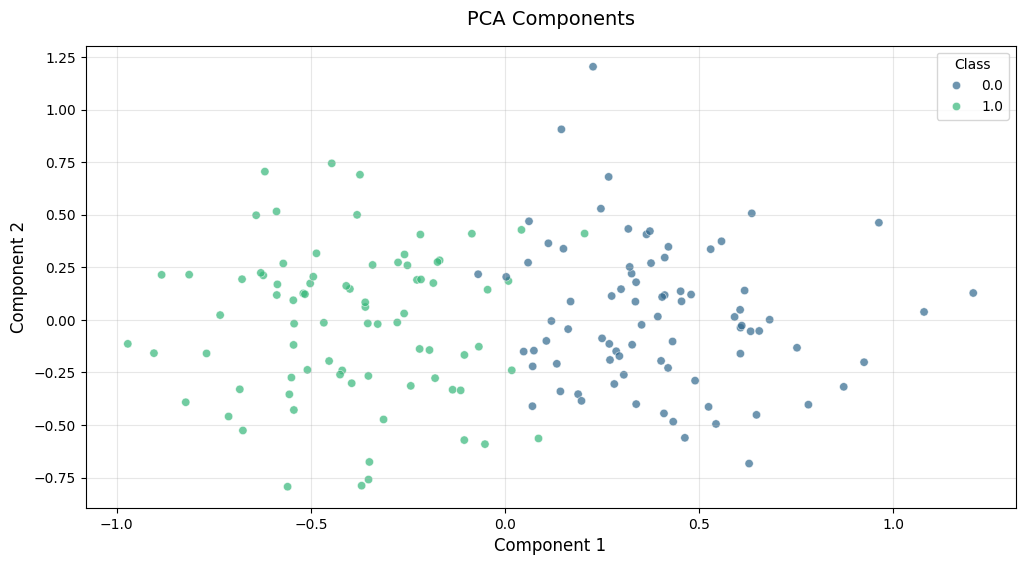

In [5]:
X_pca = getPCA(X_train.squeeze(axis=1), 2)
plot_components(X_pca, y_train)

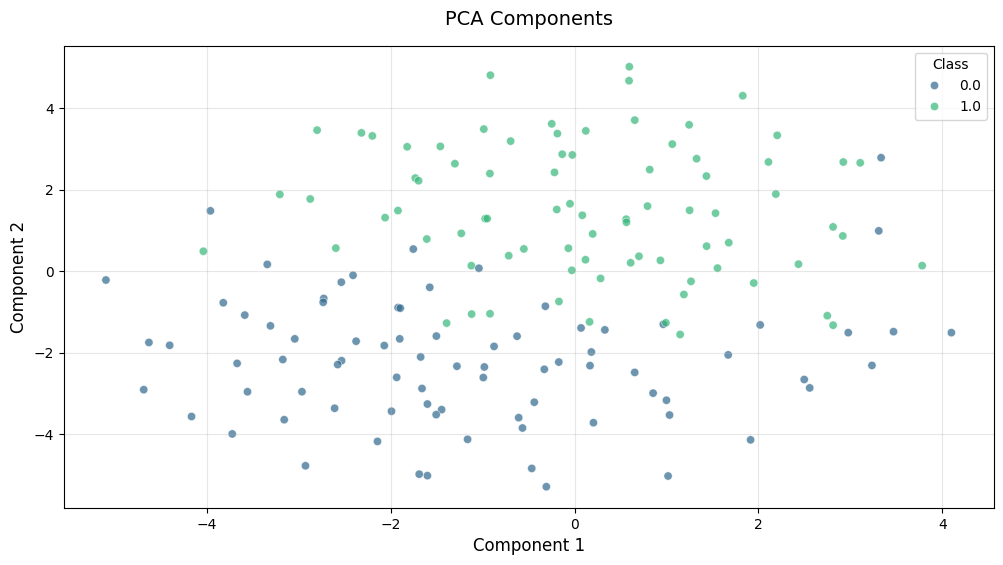

In [6]:
X_tsne = getTSNE(X_train.squeeze(axis=1), 2)
plot_components(X_tsne, y_train)

In [8]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(160, 1, 100) (40, 1, 100) (160,) (40,)


In [9]:
catch22 = Models('catch22', X_train, y_train)
catch22.train_catch22()

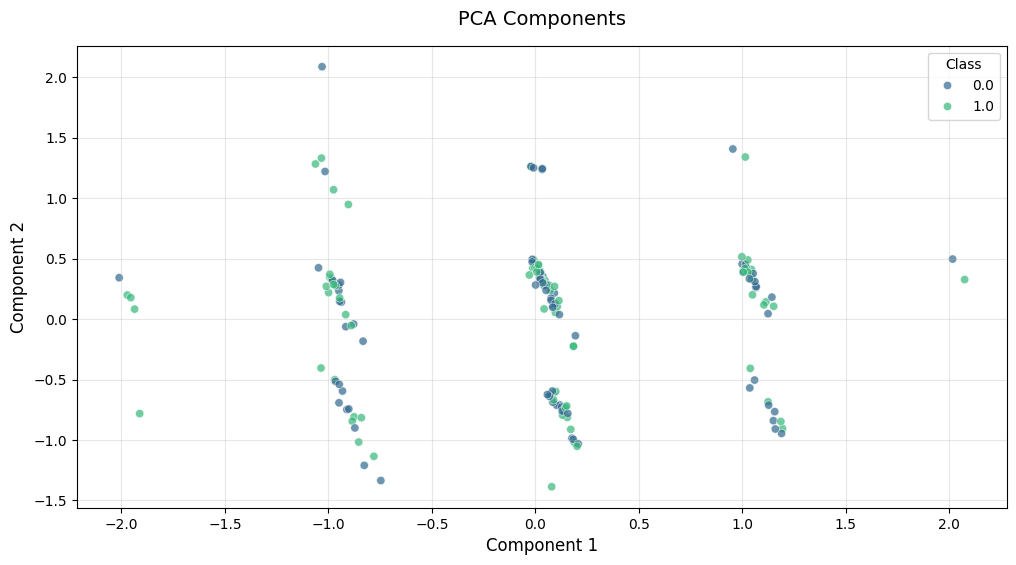

In [10]:
catch22_X_pca = getPCA(catch22.catch22_train, 2)
plot_components(catch22_X_pca, y_train)

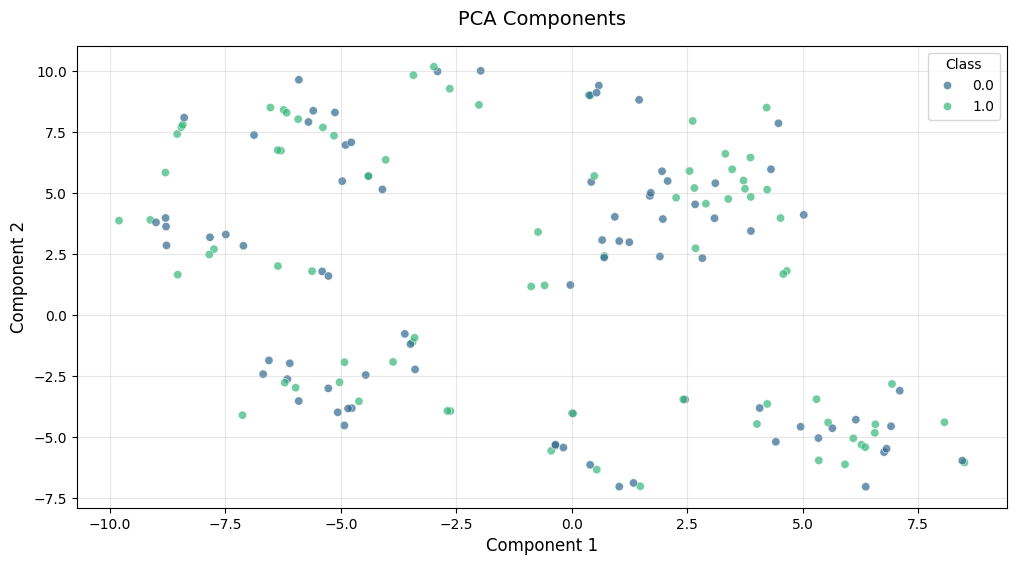

In [11]:
catch22_X_tsne = getTSNE(catch22.catch22_train, 2)
plot_components(catch22_X_tsne, y_train)

In [12]:
test = Morph(X_test, y_test)
test.get_DTWGlobalBorderline(50)

morphs, preds, results, metrics = test.Binay_MorphingCalculater(catch22, verbose=True)

Pair-Wise Results:
Pair: (9, 9) -> Morphing percentage: 0.10
Pair: (18, 6) -> Morphing percentage: 0.19
Pair: (9, 7) -> Morphing percentage: 0.17
Pair: (10, 3) -> Morphing percentage: 0.76
Pair: (3, 12) -> Morphing percentage: 0.15
Pair: (16, 3) -> Morphing percentage: 0.35
Pair: (9, 6) -> Morphing percentage: 0.09
Pair: (16, 7) -> Morphing percentage: 0.26
Pair: (13, 6) -> Morphing percentage: 0.08
Pair: (10, 12) -> Morphing percentage: 0.46
Pair: (16, 9) -> Morphing percentage: 0.09
Pair: (10, 2) -> Morphing percentage: 0.25
Pair: (16, 6) -> Morphing percentage: 0.26
Pair: (14, 2) -> Morphing percentage: 0.58
-------------------------------------------------
Mean morphing percentage: 0.27
Standard deviation of morphing percentage: 0.20
-------------------------------------------------
Correctly Classified Pairs: 14/50


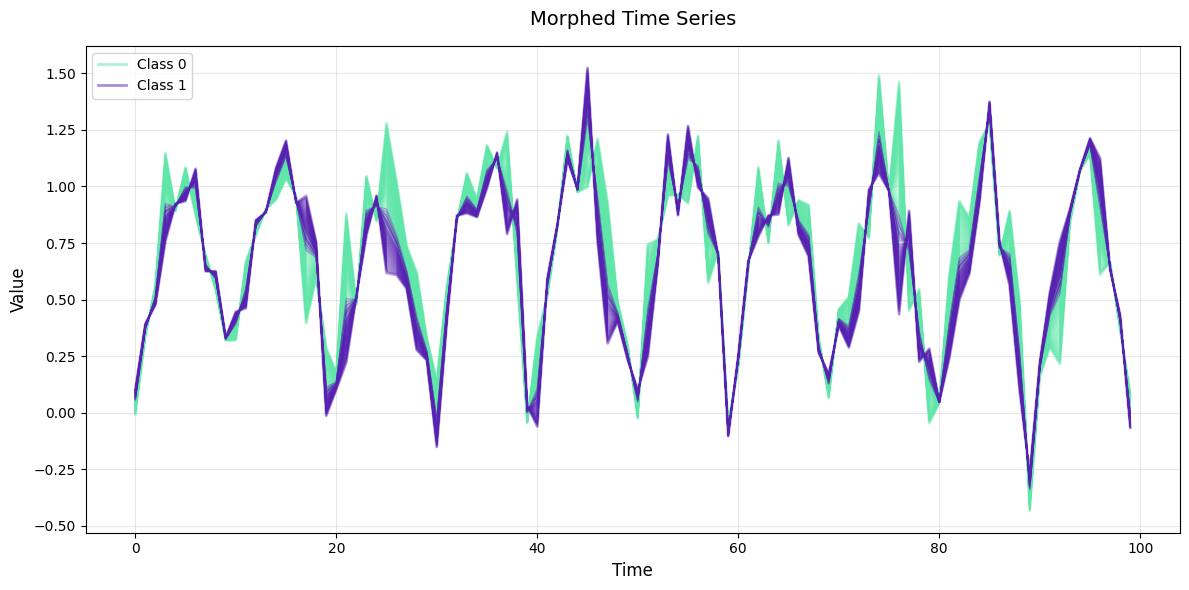

In [15]:
test.plot_morph((14,2), morphs, preds)

## Loop Through Shifts

In [15]:
# shift values = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.0]
shift_values = np.arange(0.5, -0.01, -0.05).tolist()

results = {}
for s in shift_values:
    # Generate dataset with shift
    gen = Generation(base_functions=('sin', 'sin'), n_samples=100, frequencies=(0.5,0.5), noise_level=(0.05, 0.05), shift_vert=s, shif_horz=s) 
    X, y = gen.generate_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train models
    lstm = Models('lstm', X_train, y_train)
    lstm.train_lstm()
    catch22 = Models('catch22', X_train, y_train)
    catch22.train_catch22()
    rocket = Models('rocket', X_train, y_train)
    rocket.train_rocket()

    # Calculate morphing
    res = {}
    morph = Morph(X_test, y_test)
    morph.get_DTWGlobalBorderline(50) # 50 closer pairs from different classes

    res['lsmt'] = morph.Binay_MorphingCalculater(lstm)
    res['catch22'] = morph.Binay_MorphingCalculater(catch22)
    res['rocket'] = morph.Binay_MorphingCalculater(rocket)

    results[s] = res

In [16]:
with open('results\results_sin_sin.pkl', 'wb') as f:
    pickle.dump(results, f)

In [18]:
with open('results\results_sin_sin.pkl', 'rb') as f:
    loaded_res = pickle.load(f)

In [20]:
# Create lists to store the data
data = []
for shift_val in loaded_res.keys():
    row_data = {'shift_value': float(f"{shift_val:.2f}")}
    for model in loaded_res[shift_val].keys():
        row_data[f'{model}_mean'] = loaded_res[shift_val][model][3]['mean']
        row_data[f'{model}_std'] = loaded_res[shift_val][model][3]['std']
    data.append(row_data)

df = pd.DataFrame(data)
df = df.set_index('shift_value')
df.columns = pd.MultiIndex.from_tuples([
    (col.split('_')[0], col.split('_')[1]) 
    for col in df.columns
])

df.to_csv("results\results_sin_sin.csv")
df

lsmt           catch22             rocket          
               mean       std    mean       std     mean       std
shift_value                                                       
0.50         0.5806  0.009881  0.3628  0.013422  0.47200  0.010954
0.45         0.5528  0.010591  0.4092  0.017302  0.49840  0.008570
0.40         0.5560  0.009165  0.3406  0.018375  0.47600  0.010198
0.35         0.5910  0.010247  0.3534  0.024868  0.47940  0.011732
0.30         0.5558  0.014979  0.3702  0.016792  0.49460  0.016274
0.25         0.5080  0.023324  0.3974  0.055383  0.48120  0.013363
0.20         0.5624  0.019033  0.3918  0.040184  0.46420  0.017560
0.15         0.6288  0.036641  0.3448  0.039357  0.48980  0.027458
0.10         0.5078  0.046359  0.3998  0.084297  0.46860  0.045255
0.05         0.3236  0.069793  0.3350  0.131046  0.48080  0.059995
0.00         0.0000  0.000000  0.3000  0.050000  0.35625  0.127861

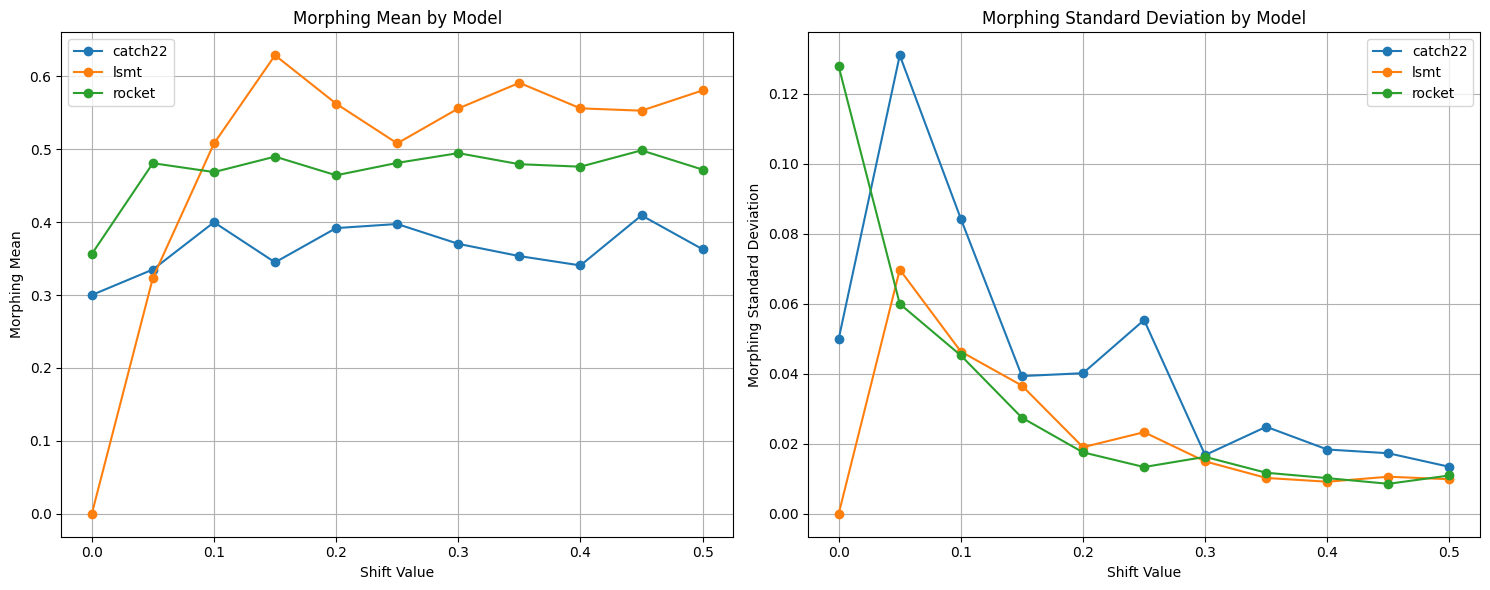

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for means
for model in df.columns.levels[0]:
    ax1.plot(df.index, df[model]['mean'], marker='o', label=model)

ax1.set_xlabel('Shift Value')
ax1.set_ylabel('Morphing Mean')
ax1.set_title('Morphing Mean by Model')
ax1.grid(True)
ax1.legend()

# Plot for standard deviations
for model in df.columns.levels[0]:
    ax2.plot(df.index, df[model]['std'], marker='o', label=model)

ax2.set_xlabel('Shift Value')
ax2.set_ylabel('Morphing Standard Deviation')
ax2.set_title('Morphing Standard Deviation by Model')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### DBA Dataset Visualization

In [2]:
import numpy as np
import importlib
tsmorph = importlib.import_module('tsmorph-xai.tsmorph.tsmorph')
TSmorph = tsmorph.TSmorph
from DBA import performDBA

def getDBA(X_morph, y_morph, plot=False):
    # seprate y_morph per target class
    if np.unique(y_morph).shape[0] != 2:
        print("Error: Target class should be binary")

    X_morph_0 = X_morph[y_morph == 0].squeeze(axis=1)
    X_morph_1 = X_morph[y_morph == 1].squeeze(axis=1)
    
    avg_class0 = performDBA(X_morph_0)
    avg_class1 = performDBA(X_morph_1)

    centers = np.array([avg_class0, avg_class1])

    if plot:
        plt.figure(figsize=(12, 6))

        for s0 in X_morph_0:
            plt.plot(s0, color='lightblue', alpha=0.3, linewidth=1, label='_')  
        for s1 in X_morph_1:
            plt.plot(s1, color='salmon', alpha=0.3, linewidth=1, label='_')
        plt.plot(avg_class0.flatten(), color='navy', linewidth=2, label='Class 0 Average')
        plt.plot(avg_class1.flatten(), color='darkred', linewidth=2, label='Class 1 Average')

        # Add labels and title
        plt.xlabel('Time Steps', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.title('Time Series by Class with DBA Averages', fontsize=14, pad=15)
        # Add grid and legend
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        # Adjust layout
        plt.tight_layout() 
        plt.show()

    return centers

squeeze done
about to strat DBA
centers done


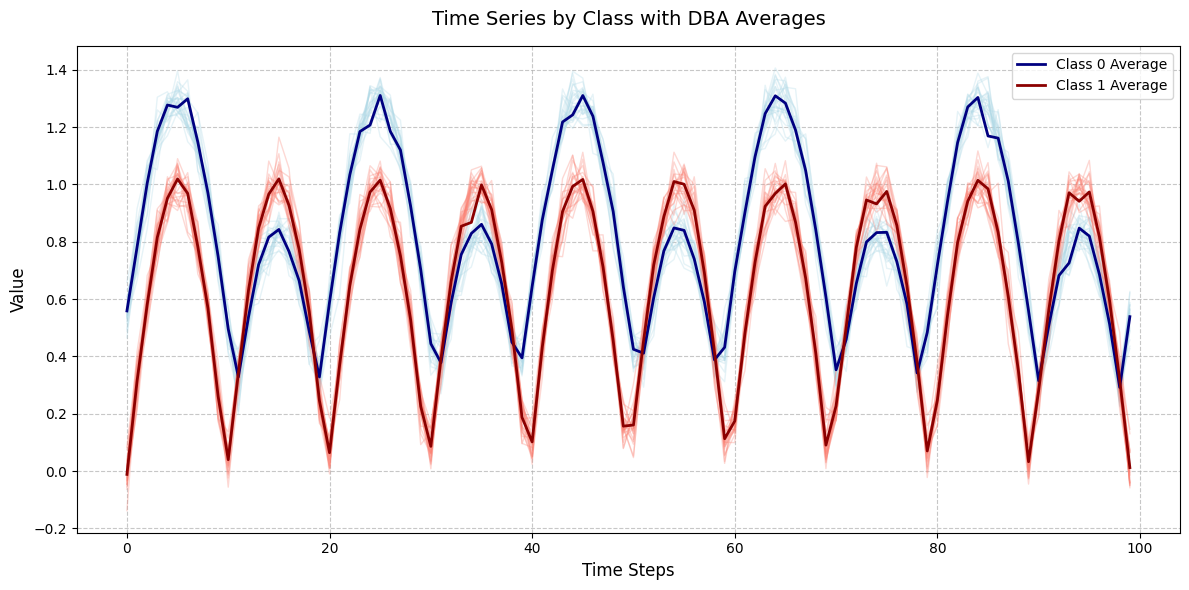

In [25]:
gen = Generation(base_functions=('sin', 'sin'), n_samples=50, frequencies=(0.5,0.5), noise_level=(0.05, 0.05), shift_vert=0.3, shif_horz=0.3) 
X, y = gen.generate_data()

centers = getDBA(X, y, plot=True)